In [35]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import get_linear_schedule_with_warmup

from torch.utils.data import DataLoader
from torch.optim import AdamW
import torch.nn.functional as F  
import torch
import torch.quantization
from tqdm import tqdm

import time
from sklearn.metrics import accuracy_score
from datasets import Dataset
import pyarrow as pa

import sys
sys.path.append('/kaggle/input/library/library')
from metrics import Metrics
from metrics.evaluate_classification import evaluate_classification


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SyntaxWarning)

os.makedirs("results", exist_ok=True)
kaggle_dir = '/kaggle/working/results'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42 

# 4.a) Distillation and Quantization

### 4.a).1. Distllation

For the distillation we use as a base of our student model the `Legal-DistilCamemBERT-base`model, found [here](https://huggingface.co/maastrichtlawtech/legal-distilcamembert). It is a great starting point for a distilled model to have a model that was pre-trained on legal text as this will give it an advantage that will help it to better overcome the shortcomings from being a distilled version.

As the teacher model, we use the camembert model trained in step 2.1 and, as teacher tokenizer, the base CamemBERT one.

In [12]:
camembert_10_path = '/kaggle/input/camembert-fine-tuned/models/cls_fine_tuning_camembert-base/checkpoint-10'

teacher_model = AutoModelForSequenceClassification.from_pretrained(camembert_10_path)
teacher_tokenizer = AutoTokenizer.from_pretrained("camembert-base")

student_model = AutoModelForSequenceClassification.from_pretrained("maastrichtlawtech/legal-distilcamembert")
student_tokenizer = AutoTokenizer.from_pretrained("maastrichtlawtech/legal-distilcamembert")

teacher_model.to(device)
student_model.to(device)

train_df = pl.read_parquet('/kaggle/input/swiss-judgement-data/data/FRENCH_swiss_judgment_prediction_train.parquet')
valid_df = pl.read_parquet('/kaggle/input/swiss-judgement-data/data/FRENCH_swiss_judgment_prediction_train.parquet')
test_df = pl.read_parquet('/kaggle/input/swiss-judgement-data/data/FRENCH_swiss_judgment_prediction_test.parquet')

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at maastrichtlawtech/legal-distilcamembert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The steps below explained:

1. FORMATTING: we format our dataframes as Arrow tables, as they allow us to handle data more efficiently (they process data by column, rather than by row). These tables are passed into the Dataset class, a huggingface class that handles datasets. Later, the relevant "columns" of these datasets are turned into tensors.
2. TOKENIZATION: we tokenize the text, using the student tokenizer, not the teacher one, to ensure compatibility with the model we are training. We set max length (512) for consistency across cells.
3. DATA LOADER: we initialize it with our batch size (16). This class handles the input of batches into the model, by splitting the data into batches and shuffling them. This ensures eliminate certain bias due to, for instance, the order in which the data was input.
4. TRAINING LOOP:
   * setting the train() mode enables training-specific features, such as dropout rate
   * similarly, adding the teacher logit calculation inside a no_gradient() condition disables gradient calculation, saving memory usage
   * loss is calculated as a weighted average of the teacher and student loss - these waits are a hyperparameter (on their tuning, below)
   * in the optimization step, 1) the gradients are cleared; 2) the loss calculation is backpropagated, revealing which parameters need more attention; 3) gradient clipping, preventing too big steps in gradient updating; 4) optimizer and scheduler (which updates the learning rate) are updated.
5. VALIDATION: validation loss is calculated

In [14]:
### FORMATTING
train_arrow = pa.Table.from_pydict(train_df.to_dict(as_series=False))
valid_arrow = pa.Table.from_pydict(valid_df.to_dict(as_series=False))
test_arrow = pa.Table.from_pydict(test_df.to_dict(as_series=False))

train_dataset = Dataset(train_arrow)
valid_dataset = Dataset(valid_arrow)
test_dataset = Dataset(test_arrow)

### TOKENIZATION
def tokenize_function(df):
    return student_tokenizer(df["text"], truncation=True, padding="max_length", max_length=512, return_tensors=None)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_valid = valid_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

### MORE FORMATTING 
columns = ['input_ids', 'attention_mask', 'label']

tokenized_train.set_format(type='torch', columns=columns)
tokenized_valid.set_format(type='torch', columns=columns)
tokenized_test.set_format(type='torch', columns=columns)

### INITIALIZE DATA LOADER
g = torch.Generator()
g.manual_seed(seed)
train_loader = DataLoader(tokenized_train, batch_size=16, shuffle=True, generator=g)

### OPTIMIZATION LOOP
## PARAMETERS AND VARIABLES TO INITIALIZE
epochs = 3

student_model.train() # turn on training mode
teacher_model.eval()

dist_weight, ce_weight = 0.7, 0.3  # distillation loss weight, cross-entropy loss weight
T = 2.0 # temperature
optimizer = AdamW(student_model.parameters(), lr=5e-5)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=100,
                                            num_training_steps=len(train_loader) * epochs)

Map:   0%|          | 0/21354 [00:00<?, ? examples/s]

Map:   0%|          | 0/21354 [00:00<?, ? examples/s]

Map:   0%|          | 0/3087 [00:00<?, ? examples/s]

In [15]:
for epoch in range(epochs):
    student_model.train()  
    epoch_loss = 0
    
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # no gradient on this part because we don't have to train the teacher
        with torch.no_grad():
            teacher_logits = teacher_model(input_ids, attention_mask).logits
            
        # student forward
        student_logits = student_model(input_ids, attention_mask).logits

        ### LOSS CALCULATION ##
        distill_loss = F.kl_div(F.log_softmax(student_logits / T, dim=-1), 
                                F.softmax(teacher_logits / T, dim=-1),    
                                reduction="batchmean",
                                log_target=False) * (T ** 2) 
        
        ce_loss = F.cross_entropy(student_logits, labels)
        # weighted average
        loss = dist_weight * distill_loss + ce_weight * ce_loss
        # accumulated loss
        epoch_loss  += loss.item() 

        # optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    print(f"Epoch {epoch+1} Loss: {epoch_loss / len(train_loader):.4f}")
    
### VALIDATION
student_model.eval()
val_loss = 0.0

with torch.no_grad():
    for batch in DataLoader(tokenized_valid, batch_size=16):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = student_model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        val_loss += F.cross_entropy(outputs.logits, batch["label"]).item()

print(f"Validation Loss: {val_loss / len(tokenized_valid):.4f}")

Epoch 1 Loss: 0.1932
Epoch 2 Loss: 0.1892
Epoch 3 Loss: 0.1836
Validation Loss: 0.0331


In [28]:
### TEST DATA LOADER
test_loader = DataLoader(tokenized_test, batch_size=16)

student_model.eval()  # turn on eval mode

correct, total, test_loss = 0, 0, 0.0
all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for batch in test_loader:
        # move everything to gpu
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # forward pass
        outputs = student_model(input_ids, attention_mask)
        logits = outputs.logits

        # get loss
        loss = F.cross_entropy(logits, labels)
        test_loss += loss.item()

        # get predictions
        predictions = torch.argmax(logits, dim=-1)

        all_labels.extend(labels.cpu().tolist())
        all_preds.extend(predictions.cpu().tolist())
                
        # also store probabilities
        probs = torch.softmax(logits, dim=-1)
        all_probs.extend(probs.cpu().tolist())
        
        # count correct predictions
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

### AVG LOSS AND ACCURACY
avg_test_loss = test_loss / len(test_loader)

print(f"Test Loss: {avg_test_loss:.4f}")

Test Loss: 0.5823


              precision    recall  f1-score   support

           0       0.82      0.89      0.86      2362
           1       0.51      0.37      0.43       725

    accuracy                           0.77      3087
   macro avg       0.67      0.63      0.64      3087
weighted avg       0.75      0.77      0.76      3087



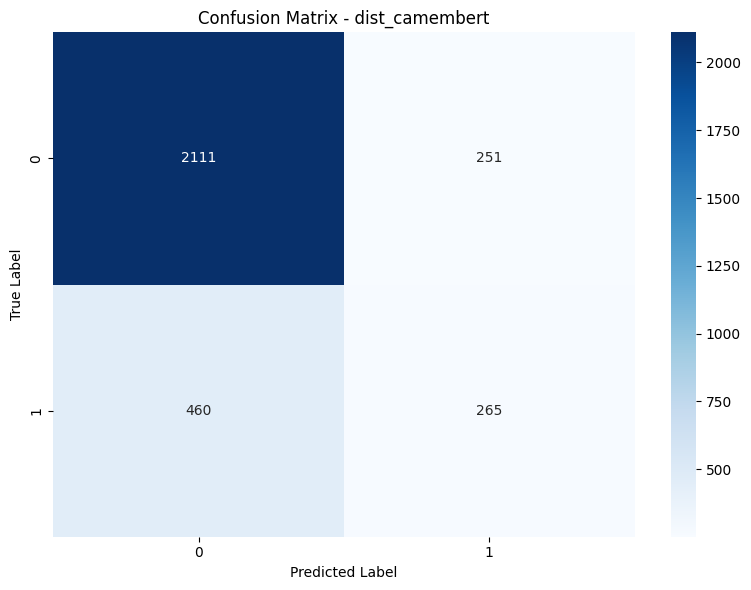

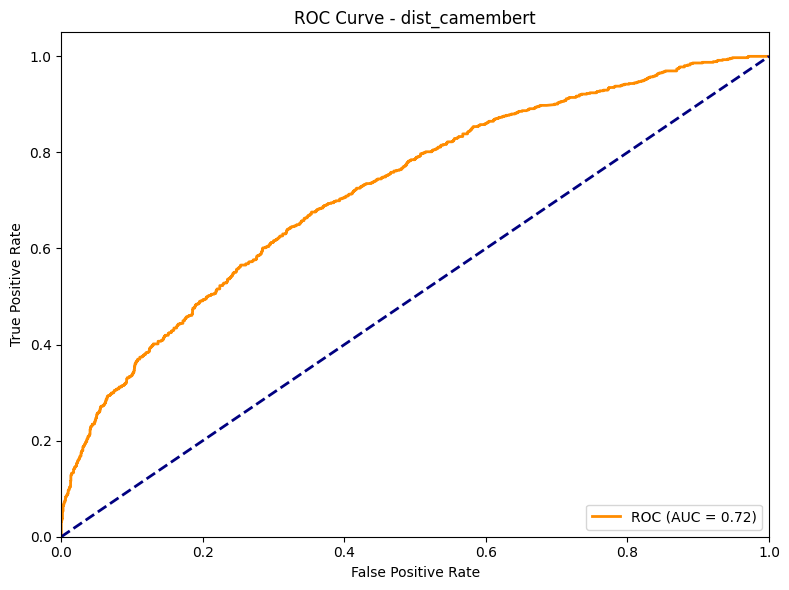

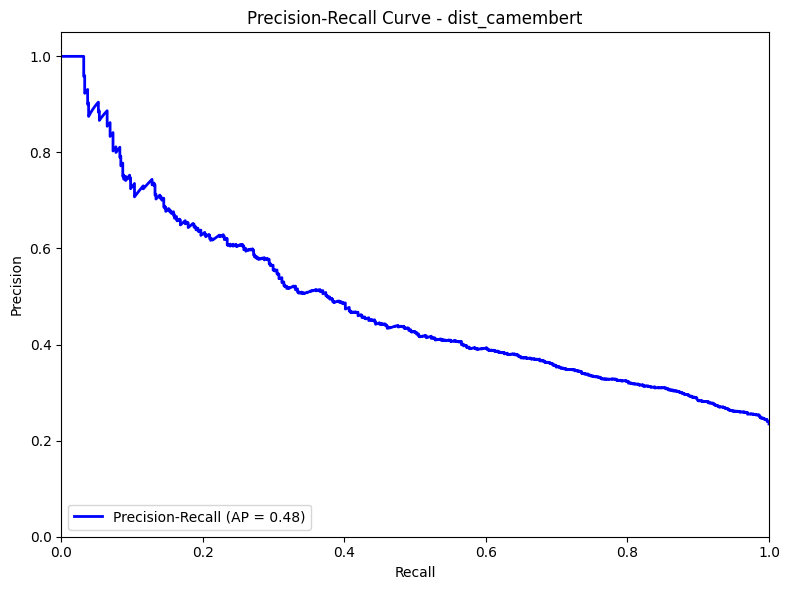

In [34]:
y_true_test = test_df['label'].to_list()
y_prob_test = np.array(all_probs)[:, 1]

threshold = 0.5
y_pred_test = (y_prob_test >= threshold).astype(int)  # if >= 0.5 → 1, else → 0

dist_camembert_results = evaluate_classification(y_true_test, y_pred_test, 'dist_camembert', [0,1], y_prob_test, kaggle_dir)

## 4.a).2. Quantization

Quantization reduces the model size by reducing the precision of its parameters, usually by transforming them from 32-bit floating point (float32) to 8-bit integers (int8). The process is much simpler and much faster because it does not require any retraining, it just "re-formats" the numbers. 

In [48]:
teacher_model_cpu = teacher_model.to('cpu') # create a CPU version for this task
quantized_student_model = torch.quantization.quantize_dynamic(teacher_model_cpu,
                                                              {torch.nn.Linear},
                                                              dtype=torch.qint8)  # quantize to 8-bit integers
                                                             
torch.save(quantized_student_model.state_dict(), 'quantized_student_model.pth')


In [ ]:
quantized_student_model.eval()
quantized_student_model.to('cpu')

test_loader = DataLoader(tokenized_test, batch_size=16)

correct, total, test_loss = 0, 0, 0.0
all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for batch in test_loader:
        # move batch tensors to CPU
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        # forward pass through quantized model
        outputs = quantized_student_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # loss
        loss = F.cross_entropy(logits, labels)
        test_loss += loss.item()

        # predictions
        predictions = torch.argmax(logits, dim=-1)

        all_labels.extend(labels.tolist())
        all_preds.extend(predictions.tolist())

        # softmax for class probabilities
        probs = torch.softmax(logits, dim=-1)
        all_probs.extend(probs.tolist())

        correct += (predictions == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
print(f"[Quantized Model] Test Loss: {avg_test_loss:.4f}")

In [ ]:
y_true_test = test_df['label'].to_list()
y_prob_test = np.array(all_probs)[:, 1]
y_pred_test = (y_prob_test >= threshold).astype(int)

quantized_results = evaluate_classification(y_true_test,y_pred_test,'quantized_camembert',[0, 1],y_prob_test,kaggle_dir)

# 4.2. Comparison of Teacher and Student models

In [50]:
def evaluate_model(model, dataloader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    # ACCURACY AND TIME
    start_time = time.time()
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # explicitly use named args
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    end_time = time.time()
    
    accuracy = correct / total
    inference_time = end_time - start_time

    # SIZE CALCULATION
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p") / 1e6
    os.remove("temp.p")

    return size, accuracy, inference_time

In [ ]:
student_size, student_accuracy, student_time = evaluate_model(student_model, test_loader, device)
teacher_size, teacher_accuracy, teacher_time = evaluate_model(teacher_model, test_loader, device)
quantized_size, quantized_accuracy, quantized_time = evaluate_model(quantized_student_model, test_loader, device='cpu')

print('---- TEACHER ----')
print(f"Size: {teacher_size:.1f}, Accuracy: {teacher_accuracy:.4f}, Inference Time: {teacher_time:.2f} secs")

print('\n---- STUDENT ----')
print(f"Size: {student_size:.1f}, Accuracy: {student_accuracy:.4f}, Inference Time: {student_time:.2f} secs")

print('\n---- QUANTIZED ----')
print(f"Size: {quantized_size:.1f}, Accuracy: {quantized_accuracy:.4f}, Inference Time: {quantized_time:.2f} secs")

In [ ]:
avg_time_per_batch_student = student_time / len(test_loader)
avg_time_per_batch_teacher = teacher_time / len(test_loader)
avg_time_per_batch_quantized = quantized_time / len(test_loader)

print(f"Student Model Avg Time per Batch: {avg_time_per_batch_student:.4f} secs")
print(f"Teacher Model Avg Time per Batch: {avg_time_per_batch_teacher:.4f} secs")
print(f"Quantized Model Avg Time per Batch: {avg_time_per_batch_quantized:.4f} secs")